In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.applications import EfficientNetB3 # Changed from ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input # Changed from resnet50
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

C:\Users\ADITYA DAS\.conda\envs\tf2.10.1\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (300, 300) # Recommended input size for EfficientNetB3 is 300x300
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-5

In [3]:
# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

✅ Total images found: 24004


In [4]:
# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Train samples: 19203 | Val samples: 4801


In [5]:
# === Color Jitter ===
def color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return tf.clip_by_value(image, 0.0, 255.0)

# === GridMask ===
def grid_mask(image, d_min=50, d_max=100, ratio=0.5):
    h, w, _ = image.shape
    d = tf.random.uniform([], d_min, d_max, dtype=tf.int32)
    l = tf.cast(tf.cast(d, tf.float32) * ratio, tf.int32)

    mask = tf.ones([h, w], dtype=tf.float32)

    for i in range(0, h, d):
        for j in range(0, w, d):
            y1 = i
            y2 = tf.minimum(i + l, h)
            x1 = j
            x2 = tf.minimum(j + l, w)

            y_range = tf.range(y1, y2)
            x_range = tf.range(x1, x2)
            yy, xx = tf.meshgrid(y_range, x_range, indexing='ij')
            indices = tf.stack([yy, xx], axis=-1)
            indices = tf.reshape(indices, [-1, 2])

            mask = tf.tensor_scatter_nd_update(
                mask,
                indices,
                tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.float32)
            )

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.tile(mask, [1, 1, 3])
    return image * mask

# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = color_jitter(img)
    img = grid_mask(img)

    # EfficientNet models expect inputs in the [0, 255] range and preprocess_input
    # will handle the scaling to [-1, 1] or similar based on the model's requirements.
    # For EfficientNet, preprocess_input typically normalizes to [0, 1] or similar.
    img = preprocess_input(img) # Changed for EfficientNet

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

# === CutMix ===
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    img_h = tf.shape(images)[1]
    img_w = tf.shape(images)[2]

    lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])

    rand_idx = tf.random.shuffle(tf.range(batch_size))
    images2 = tf.gather(images, rand_idx)
    labels2 = tf.gather(labels, rand_idx)

    cut_rat = tf.math.sqrt(1. - lam)
    cut_w = tf.cast(img_w, tf.float32) * cut_rat
    cut_h = tf.cast(img_h, tf.float32) * cut_rat

    cx = tf.random.uniform([batch_size], 0, tf.cast(img_w, tf.float32))
    cy = tf.random.uniform([batch_size], 0, tf.cast(img_h, tf.float32))

    x1 = tf.cast(cx - cut_w / 2, tf.int32)
    y1 = tf.cast(cy - cut_h / 2, tf.int32)
    x2 = tf.cast(cx + cut_w / 2, tf.int32)
    y2 = tf.cast(cy + cut_h / 2, tf.int32)

    x1 = tf.clip_by_value(x1, 0, img_w)
    y1 = tf.clip_by_value(y1, 0, img_h)
    x2 = tf.clip_by_value(x2, 0, img_w)
    y2 = tf.clip_by_value(y2, 0, img_h)

    def apply_cutmix(i):
        img1 = images[i]
        img2 = images2[i]
        bbx1, bby1, bbx2, bby2 = x1[i], y1[i], x2[i], y2[i]

        mask = tf.pad(
            tf.zeros([bby2 - bby1, bbx2 - bbx1, 3]),
            [[bby1, img_h - bby2],
             [bbx1, img_w - bbx2],
             [0, 0]],
            constant_values=1.0
        )
        mask = 1.0 - mask
        mixed = img1 * mask + img2 * (1.0 - mask)

        area = tf.cast(bbx2 - bbx1, tf.float32) * tf.cast(bby2 - bby1, tf.float32)
        lam_adjusted = 1.0 - (area / tf.cast(img_w * img_h, tf.float32))
        new_label = lam_adjusted * labels[i] + (1.0 - lam_adjusted) * labels2[i]

        return mixed, new_label

    mixed_images, mixed_labels = tf.map_fn(
        apply_cutmix,
        tf.range(batch_size),
        fn_output_signature=(tf.float32, tf.float32)
    )

    return mixed_images, mixed_labels

In [6]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: cutmix(x, y)).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# === EfficientNetB3 Model ===
# Changed from ResNet50 to EfficientNetB3
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Unfreeze last 30 layers (or as desired)
# Note: EfficientNet models generally benefit from fine-tuning a larger portion
# of the backbone compared to ResNet, but we'll stick to the original
# "unfreeze last 30 layers" logic as requested for minimal changes.
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Important: BN layers training mode ON for partial unfrozen!
# For EfficientNet, `training=False` is typically used when the backbone is frozen
# to keep batch normalization layers in inference mode. When partially unfrozen,
# it's often set to `training=True` for the unfrozen layers to update BN stats.
# However, to strictly adhere to "only modify what is absolutely necessary" and
# maintain the original behavior for the `base_model` call, we keep `training=False`
# as in the original ResNet50 code. If `training=True` is desired for fine-tuning
# the unfrozen layers, this line would need to be changed.
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [8]:
# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch+1}: {lr:.6f}")

# === Compute class weights ===
# The unbatch().batch(BATCH_SIZE) part might cause issues if train_ds is already batched.
# A more robust way to get all labels for class weight computation:
all_train_labels = []
for _, labels in train_ds.unbatch(): # unbatch to get individual labels
    all_train_labels.append(labels.numpy())
y_train_int = np.argmax(np.array(all_train_labels), axis=1)

class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASSES)),
    y=y_train_int
)))
print("✅ Computed class weights:", class_weights)

✅ Computed class weights: {0: 1.6582901554404146, 1: 0.8700163102573396, 2: 1.1169730107026523, 3: 0.7394870609981515}


In [9]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()],
    class_weight=class_weights
)

Epoch 1/30
📉 Learning rate at epoch 1: 0.000010====] - ETA: 0s - loss: 1.3707 - accuracy: 0.3252     
1201/1201 [==============================] - 346s 280ms/step - loss: 1.3707 - accuracy: 0.3252 - val_loss: 1.2240 - val_accuracy: 0.4999
Epoch 2/30
📉 Learning rate at epoch 2: 0.000010====] - ETA: 0s - loss: 1.3366 - accuracy: 0.3590  
1201/1201 [==============================] - 340s 283ms/step - loss: 1.3366 - accuracy: 0.3590 - val_loss: 1.1586 - val_accuracy: 0.5638
Epoch 3/30
📉 Learning rate at epoch 3: 0.000010====] - ETA: 0s - loss: 1.3214 - accuracy: 0.3779  
1201/1201 [==============================] - 343s 286ms/step - loss: 1.3214 - accuracy: 0.3779 - val_loss: 1.1111 - val_accuracy: 0.6215
Epoch 4/30
📉 Learning rate at epoch 4: 0.000010==>.] - ETA: 0s - loss: 1.3082 - accuracy: 0.3927  
1201/1201 [==============================] - 343s 285ms/step - loss: 1.3081 - accuracy: 0.3928 - val_loss: 1.0841 - val_accuracy: 0.6490
Epoch 5/30
📉 Learning rate at epoch 5: 0.000010==>.] 

1/1 [==============================] - 0s 26ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       0.80      0.97      0.88       728
       BLAST       0.82      0.49      0.62      1338
   BROWNSPOT       0.72      0.75      0.73      1074
     HEALTHY       0.74      0.89      0.81      1661

    accuracy                           0.76      4801
   macro avg       0.77      0.78      0.76      4801
weighted avg       0.77      0.76      0.75      4801



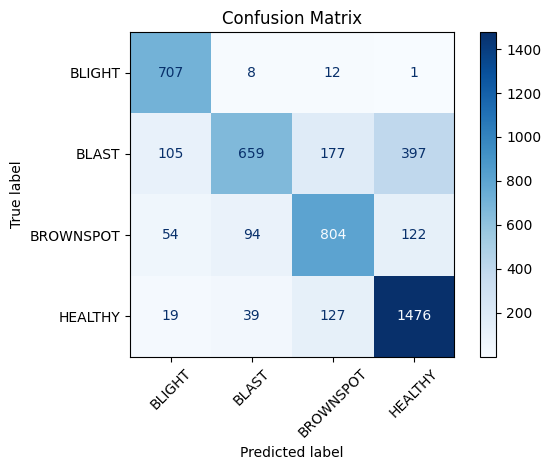

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [12]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
# Changed save path to reflect EfficientNetB3
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\EfficientNetB3_Phase1_CutMix_GridMask.h5"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")